# Modelo Integrado de Riesgo de Liquidez y Mercado
---

Este algoritmo replica la funcionalidad principal del trabajo "A Fully Integrated Liquidity and Market Risk Model" de Meucci 2012 (Financial Analysts Journal). El algoritmo usa convolución condicional para integrar el riesgo de mercado y de liquidez, generando distribuciones de P&L totales y calculando medidas como VaR y Expected Shortfall (ES).

Para la validación, se utilizan datos sintéticos (escenarios de mercado generados con distribución normal, parámetros de liquidez inspirados en modelos Almgren-Chriss). Esto permite reproducir resultados similares a los del paper (e.g., VaR ajustado por liquidez ~20-30% mayor que el de mercado solo). Es eficiente para miles de escenarios (O(N * M), con N=escenarios de mercado, M=sub-escenarios de liquidez).

https://www.mathworks.com/matlabcentral/fileexchange/43243-a-fully-integrated-liquidity-and-market-risk-model?s_tid=prof_contriblnk

## Fundamentos Teóricos (Resumen Breve)

**Riesgo de Mercado**: Escenarios de P&L $x_i$ con probabilidades $\pi_i$, generados vía simulación histórica o Fully Flexible Probabilities.

**Riesgo de Liquidez**: Costo estocástico $l_{i,j}$ dependiente del volumen de trading $v_i = \theta_i \cdot |w|$, donde $\theta_i$ es la fracción liquidada según política $\phi(x_i)$. Modelo: $l \sim \mathcal{N}(\eta v^\gamma, (\sigma_l v^\gamma)^2)$.

**Integración**: Convolución condicional: P&L total $p_{i,j} = x_i + l_{i,j}$, con pesos $\pi_i / M$.

**Medidas**: VaR_\alpha = -q_\alpha (cuantil \alpha de la distribución total); ES_\alpha = \mathbb{E}[-P&L | P&L \leq -VaR_\alpha].
Innovación: La liquidez varía por escenario, capturando dependencias (e.g., más liquidación en pérdidas).

## Implementación Paso a Paso

El algoritmo sigue estos pasos, mirroring la convolución condicional del MATLAB:

**Generar Escenarios de Mercado**: Crear N escenarios $\{x_i\}$ de P&L de mercado (e.g., normal para simplicidad; en MATLAB, usa Entropy Pooling).
Definir Política de Liquidación: Para cada $x_i$, calcular $\theta_i = \phi(x_i)$ (e.g., 50% si pérdida).

**Modelar Costos de Liquidez**: Para volumen $v_i$, generar M sub-escenarios $l_{i,j}$ de la distribución condicional.

**Convolución Condicional**: Construir lista de todos $p_{i,j} = x_i + l_{i,j}$ con pesos uniformes $\pi_i / M$.

**Calcular Medidas de Riesgo**: Ordenar P&L ponderados, encontrar cuantil para VaR; promedio ponderado en la cola para ES.

Descomposición (Opcional): Comparar VaR de mercado solo vs. total para atribuir a liquidez.


## Código Completo en Python

In [ ]:
import numpy as np
import scipy.io as sio
import scipy.stats as stats
import matplotlib.pyplot as plt

# Configuración de Semilla para reproducibilidad
np.random.seed(11)

In [ ]:
# 1. CARGAR DATOS
# ==========================================
# Cargamos el archivo MAT proporcionado
data = sio.loadmat('DB.mat')

# Extraemos las variables (ajustando nombres si es necesario según el archivo)
# En MATLAB: Daily_Prices, Daily_Volumes_Shares, Daily_Liq
# Nota: En Python los arrays son (filas, columnas)
Daily_Prices = data['Daily_Prices']
Daily_Volumes_Shares = data['Daily_Volumes_Shares']
Daily_Liq = data['Daily_Liq']

In [ ]:
# 2. PARÁMETROS (Inputs del usuario en S_Main.m)
# ==========================================
# Política de liquidación (fracción de la inversión a vender)
Policy = -1
# Colinealidad de las perturbaciones de liquidez
CollinLiq = 1
# Selección de stocks (primeros 10 activos)
# MATLAB usa índices base-1 (1:10), Python base-0 (0:10)
Selectstock = slice(0, 10)
Capital_perDailyVolume = 0.2
J = 100000 # Número de simulaciones

In [ ]:
# 3. PREPARACIÓN DE DATOS
# ==========================================
# Filtrar solo los stocks seleccionados
Prices_sub = Daily_Prices[:, Selectstock]
Volumes_sub = Daily_Volumes_Shares[:, Selectstock]

# Precios actuales (última fila)
Prices_0 = Prices_sub[-1, :].reshape(-1, 1) # Convertir a vector columna (N, 1)

# Retornos Logarítmicos: ln(P_t / P_{t-1})
# MATLAB: prices(1:end-1,:) ./ prices(2:end,:) -> Ojo: MATLAB calcula retornos al revés o forward?
# En finanzas log ret suele ser log(Pt / Pt-1).
# El código MATLAB hace: log(Daily_Prices(1:end-1,:)./Daily_Prices(2:end,:));
# Eso es log(P_{t-1} / P_t) = - log(P_t / P_{t-1}).
# Seguiremos la lógica exacta de MATLAB para replicar resultado.
Daily_LogRets = np.log(Prices_sub[:-1, :] / Prices_sub[1:, :])

# Dimensiones
T_hist, N = Daily_LogRets.shape

# Volúmenes
Volumes_0 = Volumes_sub[-1, :].reshape(-1, 1)
# Promedio de los últimos 250 días
Volumes_t = np.mean(Volumes_sub[-250:, :], axis=0).reshape(-1, 1)

# Liquidez (Diferencias del índice)
# Daily_LiqChanges = diff(Daily_Liq)
Daily_LiqChanges = np.diff(Daily_Liq, axis=0)
Liq_0 = Daily_Liq[-1, :].reshape(-1, 1)

In [ ]:
# 4. SIMULACIÓN DE MONTE CARLO (Normal Multivariada)
# ==========================================
# Unir factores de riesgo: Retornos y Cambios de Liquidez
# X = [Daily_LogRets  Daily_LiqChanges]
X = np.hstack((Daily_LogRets, Daily_LiqChanges))

# Estadísticas
m_X = np.mean(X, axis=0)
s2_X = np.cov(X, rowvar=False)

# Simulación
# Generamos J escenarios
X_sim = np.random.multivariate_normal(m_X, s2_X, J)

# Separar simulaciones
Sim_LogRets = X_sim[:, :N]       # (J, N)
Sim_LiqChanges = X_sim[:, N:]    # (J, k)

# Probabilidades (Flexibles, aquí uniformes)
Probs = np.ones((J, 1)) / J

In [ ]:
# 5. PROYECCIÓN AL HORIZONTE
# ==========================================
# Precios futuros: P_t = P_0 * exp(r)
# Transponemos Prices_0 para broadcasting correcto (1, N)
Prices_t = Daily_Prices[-1, Selectstock] * np.exp(Sim_LogRets) # (J, N)

# P&L de Mercado Puro
# PnL = Precio_Simulado - Precio_Inicial
PnL_mkt = Prices_t - Daily_Prices[-1, Selectstock] # (J, N)

In [ ]:
# 6. CÁLCULOS DEL PORTAFOLIO
# ==========================================
# Pesos iguales (1/N)
Weights = np.zeros((N, 1))
Weights[:] = 1.0 / N

# Capital = 0.2 * DollarVolume Diario
DollarVolume_0 = np.sum(Volumes_0 * Prices_0)
Capital = Capital_perDailyVolume * DollarVolume_0

# Tenencia (h) = Capital * Pesos / Precios
h = (Capital * Weights) / Prices_0 # (N, 1)

# P&L del Portafolio (Mercado)
# (J, N) @ (N, 1) -> (J, 1)
PnL_mkt_h = PnL_mkt @ h

In [ ]:
# 7. AJUSTE DE LIQUIDEZ
# ==========================================
# Política de liquidación: Dh = Policy * h
Dh = Policy * h # (N, 1)

# Impacto de Mercado (Market Impact)
# b_a = bid-ask spread parameter
b_a = 0.01 * np.ones((N, 1))

# Costo Lineal (Spread)
Linear = -b_a * Prices_0 * np.abs(Dh)

# Costo No Lineal (Impacto por volumen)
# Formula: -10^5 * Price * Volatilidad * (Dh / Vol_medio)^1.5
# Calculamos desviación estándar de retornos históricos por activo
std_rets = np.std(Daily_LogRets, axis=0).reshape(-1, 1)
NonLinear = -(10**5) * Prices_0 * std_rets * ((np.abs(Dh) / Volumes_t)**1.5)

# Esperanza del costo de liquidez (por stock)
m_Dh = Linear + NonLinear # (N, 1)

# --- Impacto dependiente del estado (State-dependent) ---
# Definimos la función "g1" que agrava el costo si el P&L es muy negativo
s_g1 = 0.5 * np.std(PnL_mkt_h)
# g1 = -min(PnL, -s_g1) / s_g1
# Usamos np.minimum elemento a elemento
g1 = -np.minimum(PnL_mkt_h, -s_g1) / s_g1 # (J, 1)

# Costo esperado condicional al escenario
# m_Dh_x = g1 * m_Dh' -> (J, 1) * (1, N) = (J, N)
m_Dh_x = np.tile(g1, (1, N)) * np.tile(m_Dh.T, (J, 1))

# Costo esperado total del portafolio en cada escenario
# Sumamos sobre todos los stocks
m_Dh_h = np.sum(m_Dh_x, axis=1).reshape(-1, 1) # (J, 1)

# --- Incertidumbre del impacto (Varianza) ---
s_Dh = 1.5 * m_Dh # La incertidumbre es proporcional al costo esperado
# Correlación
corr_rets = np.corrcoef(Daily_LogRets, rowvar=False)
r2_Dh = (1 - CollinLiq) * corr_rets + CollinLiq * np.ones((N, N))

# Covarianza del impacto: S * R * S
s2_Dh = np.diag(s_Dh.flatten()) @ r2_Dh @ np.diag(s_Dh.flatten())

# Varianza total del portafolio (scalar)
# ones' * s2_Dh * ones
s2_Dh_h = np.sum(s2_Dh)
s_Dh_h_val = np.sqrt(s2_Dh_h)

# Regularización (evitar sigma=0)
s_Dh_h_val = max(s_Dh_h_val, 0.01 * np.std(PnL_mkt_h))

In [ ]:
# 8. P&L TOTAL (Convolución)
# ==========================================
# Media condicional: P&L Mercado + Costo Liquidez Esperado (que es negativo)
m_j = PnL_mkt_h + m_Dh_h # (J, 1)
# Desviación estándar condicional (asumida constante en este script simplificado)
s_j = s_Dh_h_val * np.ones((J, 1))

# Definición de la PDF final (Mezcla de t-students)
# f_Pi(x) = promedio de densidades t centradas en m_j con escala s_j
nu = 100 # Grados de libertad (casi normal)

def get_pdf_at_x(x_val, means, scales, df):
    # Vectorización: calculamos pdf para todos los escenarios J a la vez y promediamos
    densities = stats.t.pdf((x_val - means) / scales, df) / scales
    return np.mean(densities)

# Generar Grid para graficar
min_x = np.min(PnL_mkt_h) - s_Dh_h_val
max_x = np.max(PnL_mkt_h) + s_Dh_h_val
x_grid = np.linspace(min_x, max_x, 200)

f_Pi_plot = []
for x in x_grid:
    pdf_val = get_pdf_at_x(x, m_j, s_j, nu)
    f_Pi_plot.append(pdf_val)

f_Pi_plot = np.array(f_Pi_plot)

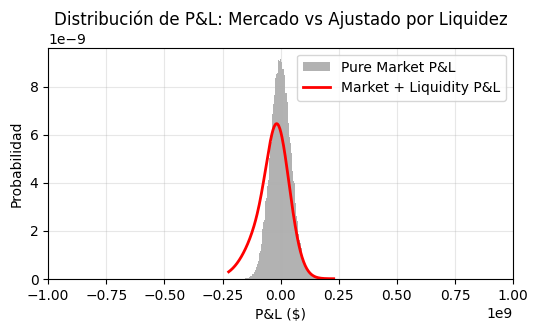

In [ ]:
# 9. GRAFICAR
# ==========================================
plt.figure(figsize=(6, 3))

# Histograma del P&L de Mercado Puro (Gris)
plt.hist(PnL_mkt_h, bins=int(10 * np.log(J)), density=True,
         color='gray', alpha=0.6, label='Pure Market P&L')

# Línea Roja: P&L Ajustado por Liquidez
plt.plot(x_grid, f_Pi_plot, 'r-', linewidth=2, label='Market + Liquidity P&L')

plt.title("Distribución de P&L: Mercado vs Ajustado por Liquidez")
plt.xlabel("P&L ($)")
plt.ylabel("Probabilidad")
plt.legend()
plt.xlim([-10**9, 10**9]) # Ajuste visual según el MATLAB original
plt.grid(True, alpha=0.3)
plt.show();